# Deep Food Image Classifier with ES(1+1)

**Author:** V. Harsha Vardhan Yellela  
**Course:** MCS-5993 Evolutionary Computing & Deep Learning  
**Institution:** Lawrence Technological University  
**Date:** 2025-11-09

**Description:**  
Dataset preparation and baseline CNN model training for American food image classification.  
Built from scratch using Keras/TensorFlow with multi-GPU mixed-precision acceleration.

### Imports and configuration

In [1]:
import os
import random
import shutil
import json
from pathlib import Path
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    try:
        tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError:
        pass  # already initialized

tf.config.threading.set_intra_op_parallelism_threads(4)
tf.config.threading.set_inter_op_parallelism_threads(4)


SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

DATA_ROOT = Path(
    # r"/mnt/d/Desktop/MCS-5993-Evolutionary-Computation-and-Deep-Learning/Term-project[Deep Food image classifier]/Dataset"
    r"/home/har5ha/term_project/Dataset"
)
SRC_DIR = DATA_ROOT / "food-american"
OUT_DIR = DATA_ROOT / "dataset_split"

# Optimized for dual RTX 3090 (48GB total VRAM)
IMG_SIZE = (224, 224)  # Higher resolution for better feature learning
RATIOS = (0.7, 0.15, 0.15)
BATCH = 48  # Reduced from 64 to prevent OOM during ES optimization


print("DATA_ROOT:", DATA_ROOT)
print("SRC_DIR:", SRC_DIR)
print("OUT_DIR:", OUT_DIR)


2025-11-16 21:15:15.349047: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


DATA_ROOT: /home/har5ha/term_project/Dataset
SRC_DIR: /home/har5ha/term_project/Dataset/food-american
OUT_DIR: /home/har5ha/term_project/Dataset/dataset_split


### Utility functions for dataset splitting

In [2]:
def reset_dir(path: Path):
    if path.exists():
        shutil.rmtree(path)
    path.mkdir(parents=True, exist_ok=True)

def list_images(folder: Path):
    exts = {".jpg", ".jpeg", ".png", ".bmp"}
    return [p for p in folder.iterdir() if p.suffix.lower() in exts]

def split_and_copy(src_dir: Path, out_dir: Path, ratios=(0.7, 0.15, 0.15)):
    train_r, val_r, test_r = ratios
    assert abs(train_r + val_r + test_r - 1.0) < 1e-6

    for split in ["train", "val", "test"]:
        (out_dir / split).mkdir(parents=True, exist_ok=True)

    classes = sorted([d.name for d in src_dir.iterdir() if d.is_dir()])
    for cls in classes:
        src_cls = src_dir / cls
        imgs = list_images(src_cls)
        random.shuffle(imgs)

        n = len(imgs)
        n_train = int(n * train_r)
        n_val = int(n * val_r)

        splits = {
            "train": imgs[:n_train],
            "val": imgs[n_train:n_train + n_val],
            "test": imgs[n_train + n_val:]
        }

        for split, files in splits.items():
            dst_cls = out_dir / split / cls
            dst_cls.mkdir(parents=True, exist_ok=True)
            for f in files:
                shutil.copy2(f, dst_cls / f.name)

    with open(out_dir / "classes.json", "w") as f:
        json.dump(classes, f, indent=2)
    return classes

if not (OUT_DIR / "train").exists():
    reset_dir(OUT_DIR)
    classes = split_and_copy(SRC_DIR, OUT_DIR, RATIOS)
    print("New train/val/test split created.")
else:
    classes = sorted([d.name for d in (OUT_DIR / "train").iterdir() if d.is_dir()])
    print(f"Existing split detected. {len(classes)} classes loaded.")


# choice = input("Choose an option:\n1. Create new split\n2. Use existing split\nEnter 1 or 2: ").strip()

# if choice == "1":
#     reset_dir(OUT_DIR)
#     classes = split_and_copy(SRC_DIR, OUT_DIR, RATIOS)
#     print(f"{len(classes)} classes prepared.")
# elif choice == "2":
#     classes = sorted([d.name for d in (OUT_DIR / "train").iterdir() if d.is_dir()])
#     print(f"{len(classes)} classes loaded from existing split.")
# else:
#     print("Invalid choice. Please run the cell again and enter 1 or 2.")

Existing split detected. 25 classes loaded.


### Verify split distribution

In [3]:
def count_per_split(out_dir: Path):
    stats = {}
    for split in ["train", "val", "test"]:
        split_dir = out_dir / split
        counts = {}
        for cls_dir in sorted([d for d in split_dir.iterdir() if d.is_dir()]):
            counts[cls_dir.name] = len(list_images(cls_dir))
        stats[split] = counts
    return stats

stats = count_per_split(OUT_DIR)
for split in ["train", "val", "test"]:
    total = sum(stats[split].values())
    print(f"{split.upper():5s} | total={total}")

TRAIN | total=17500
VAL   | total=3750
TEST  | total=3750


### Data generators and preprocessing

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    horizontal_flip=True,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    brightness_range=(0.9, 1.1),
    fill_mode="nearest",
)

val_test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_gen = train_datagen.flow_from_directory(
    directory=str(OUT_DIR / "train"),
    target_size=IMG_SIZE,
    class_mode="categorical",
    shuffle=True,
    batch_size=BATCH,
    seed=SEED,
)

val_gen = val_test_datagen.flow_from_directory(
    directory=str(OUT_DIR / "val"),
    target_size=IMG_SIZE,
    class_mode="categorical",
    shuffle=False,
    batch_size=BATCH,
)

test_gen = val_test_datagen.flow_from_directory(
    directory=str(OUT_DIR / "test"),
    target_size=IMG_SIZE,
    class_mode="categorical",
    shuffle=False,
    batch_size=BATCH,
)

with open(OUT_DIR / "class_indices.json", "w") as f:
    json.dump(train_gen.class_indices, f, indent=2)

Found 17500 images belonging to 25 classes.
Found 3750 images belonging to 25 classes.
Found 3750 images belonging to 25 classes.
Found 3750 images belonging to 25 classes.
Found 3750 images belonging to 25 classes.


### Visual sanity check

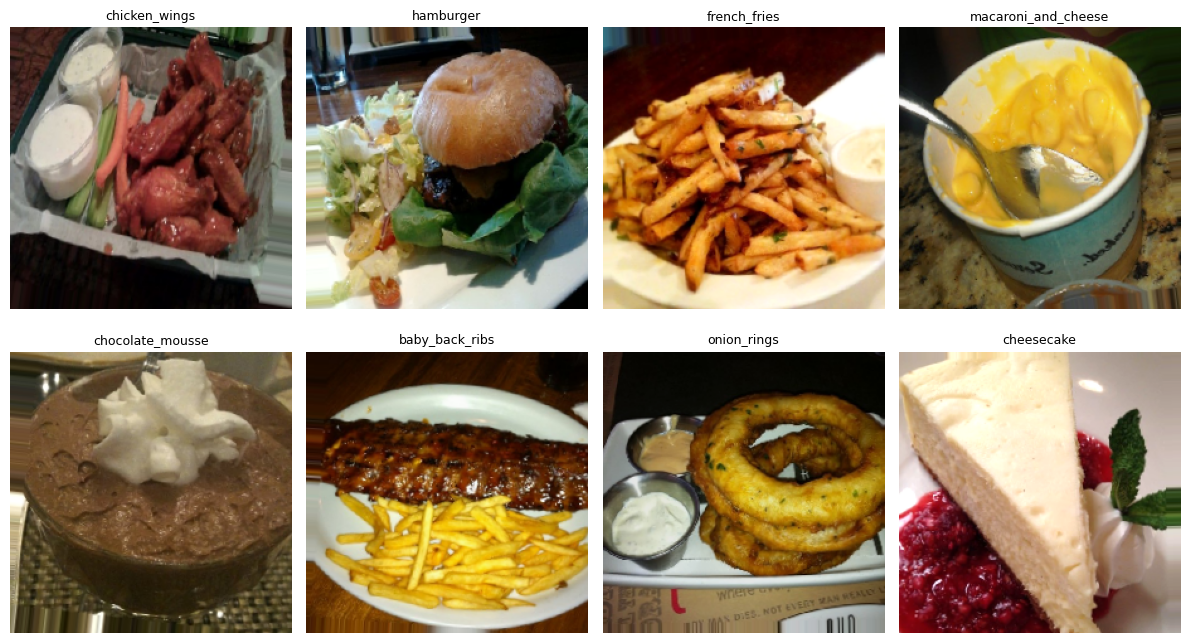

In [5]:
batch_x, batch_y = next(train_gen)
labels = {v: k for k, v in train_gen.class_indices.items()}

plt.figure(figsize=(12, 10))
for i in range(8):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(batch_x[i])
    cls_idx = np.argmax(batch_y[i])
    plt.title(labels[cls_idx], fontsize=9)
    plt.axis("off")
plt.tight_layout()
plt.show()

### Confidence threshold helper for inference

In [6]:
def top1_with_threshold(probs, idx_to_class, threshold=0.5):
    top_idx = int(np.argmax(probs))
    conf = float(probs[top_idx])
    if conf < threshold:
        return {"label": "Not an American food — outside scope", "confidence": conf}
    return {"label": idx_to_class[top_idx], "confidence": conf}

### CNN architecture (from scratch)

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Dropout, Dense, BatchNormalization, GlobalAveragePooling2D,
    Input, Add, Activation
)

def build_baseline_cnn(input_shape=(224, 224, 3), n_classes=25):
    """Improved CNN with residual connections for better gradient flow"""
    inputs = Input(shape=input_shape)
    
    # Initial conv - LESS aggressive downsampling to preserve spatial detail
    x = Conv2D(64, 7, strides=2, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(3, strides=1, padding="same")(x)  # Changed stride 2->1
    
    # Residual Block 1 (64 -> 128 channels)
    shortcut = Conv2D(128, 1, strides=2, padding="same")(x)
    shortcut = BatchNormalization()(shortcut)
    
    x = Conv2D(128, 3, strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(128, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Add()([x, shortcut])
    x = Activation("relu")(x)
    x = Dropout(0.25)(x)
    
    # Residual Block 2 (128 -> 256 channels)
    shortcut = Conv2D(256, 1, strides=2, padding="same")(x)
    shortcut = BatchNormalization()(shortcut)
    
    x = Conv2D(256, 3, strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(256, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Add()([x, shortcut])
    x = Activation("relu")(x)
    x = Dropout(0.25)(x)
    
    # Residual Block 3 (256 -> 512 channels)
    shortcut = Conv2D(512, 1, strides=2, padding="same")(x)
    shortcut = BatchNormalization()(shortcut)
    
    x = Conv2D(512, 3, strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(512, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Add()([x, shortcut])
    x = Activation("relu")(x)
    x = Dropout(0.25)(x)
    
    # Residual Block 4 (512 -> 1024 channels) - NEW for better capacity
    shortcut = Conv2D(1024, 1, strides=2, padding="same")(x)
    shortcut = BatchNormalization()(shortcut)
    
    x = Conv2D(1024, 3, strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(1024, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Add()([x, shortcut])
    x = Activation("relu")(x)
    
    # Classification head
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(n_classes, activation="softmax")(x)
    
    return Model(inputs, outputs)


### Multi-GPU strategy and mixed-precision setup

In [8]:
from tensorflow.keras import mixed_precision
from tensorflow.keras.optimizers import Adam

# Enable mixed precision for faster training on RTX 3090
mixed_precision.set_global_policy("mixed_float16")

# Multi-GPU strategy - use both GPUs
strategy = tf.distribute.MirroredStrategy()  # Auto-detects both GPUs

LR = 2e-3  # Higher LR works well with large batch size
EPOCHS = 50  # More epochs for convergence

with strategy.scope():
    model = build_baseline_cnn(input_shape=(224, 224, 3), n_classes=len(classes))
    optimizer = Adam(learning_rate=LR)

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05),  # Reduced label smoothing
        metrics=["accuracy"],
    )

print(f"\n{'='*60}")
print(f"Training on {strategy.num_replicas_in_sync} GPUs")
print(f"Effective batch size: {BATCH * strategy.num_replicas_in_sync}")
print(f"{'='*60}\n")

model.summary()


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPUs will likely run quickly with dtype policy mixed_float16 as they all have compute capability of at least 7.0
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/

##  Baseline_CNN_model_training

### Convert generators to tf.data pipelines for faster throughput

In [ ]:
from tensorflow.keras import layers

AUTOTUNE = tf.data.AUTOTUNE

# CRITICAL FIX: Add normalization layer to rescale pixels from 0-255 to 0-1
normalization = layers.Rescaling(1./255)

train_ds = tf.keras.utils.image_dataset_from_directory(
    OUT_DIR / "train",
    image_size=IMG_SIZE,
    batch_size=BATCH,
    label_mode="categorical",
    seed=SEED,
).map(lambda x, y: (normalization(x), y)).shuffle(512).prefetch(AUTOTUNE)

val_ds = tf.keras.utils.image_dataset_from_directory(
    OUT_DIR / "val",
    image_size=IMG_SIZE,
    batch_size=BATCH,
    label_mode="categorical",
).map(lambda x, y: (normalization(x), y)).prefetch(AUTOTUNE)


Found 17500 files belonging to 25 classes.
Found 3750 files belonging to 25 classes.
Found 3750 files belonging to 25 classes.


In [ ]:
from tensorflow.keras import layers

# Enhanced augmentation for better generalization
aug = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])
train_ds = train_ds.map(lambda x, y: (aug(x, training=True), y),

                        num_parallel_calls=AUTOTUNE)

### Training and checkpointing

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import pandas as pd

# Callbacks optimized for longer training
callbacks = [
    EarlyStopping(
        monitor="val_accuracy", 
        patience=15,  # More patience for 50 epochs
        restore_best_weights=True, 
        verbose=1
    ),
    ModelCheckpoint(
        "baseline_cnn_best.keras", 
        monitor="val_accuracy", 
        save_best_only=True, 
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor="val_loss", 
        factor=0.3,  # More aggressive LR reduction
        patience=5, 
        min_lr=1e-7, 
        verbose=1
    ),
]

print("Number of batches per epoch:", len(train_ds))

# CRITICAL DEBUG CHECK: Verify normalization
for X, y in train_ds.take(1):
    print("Batch shape:", X.shape, y.shape)
    print("Pixel range:", f"{float(X.numpy().min()):.3f} to {float(X.numpy().max()):.3f}")
    print("Expected: ~0.0 to ~1.0")
    assert X.numpy().max() <= 1.1, "❌ Data not normalized! Training will fail."
    print("✓ Normalization verified")

# Train the model using tf.data pipelines
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1,
)

# Save learning history for documentation and plotting
pd.DataFrame(history.history).to_csv("baseline_history.csv", index=False)

# Log final results
best_val = max(history.history["val_accuracy"])
print(f"Training complete. Best validation accuracy: {best_val:.3f}")


Number of batches per epoch: 274
Batch shape: (64, 224, 224, 3) (64, 25)
Pixel range: 0.000 to 1.062
Expected: ~0.0 to ~1.0
✓ Normalization verified
Batch shape: (64, 224, 224, 3) (64, 25)
Pixel range: 0.000 to 1.062
Expected: ~0.0 to ~1.0
✓ Normalization verified
Epoch 1/50
Epoch 1/50
INFO:tensorflow:batch_all_reduce: 58 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 58 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 58 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 58 all-reduces with algorithm = nccl, num_packs = 1
270/274 [============================>.] - ETA: 0s - loss: 3.6871 - accuracy: 0.0775
Epoch 1: val_accuracy improved from -inf to 0.08773, saving model to baseline_cnn_best.keras

Epoch 1: val_accuracy improved from -inf to 0.08773, saving model to baseline_cnn_best.keras
274/274 [==============================] - 63s 161ms/step - loss: 3.6833 - accuracy: 0.0775 - val

### Evaluation on test set

59/59 [==============================] - 6s 59ms/step - loss: 1.6044 - accuracy: 0.6437
Test Accuracy: 64.37%
Test Accuracy: 64.37%
59/59 [==============================] - 6s 76ms/step


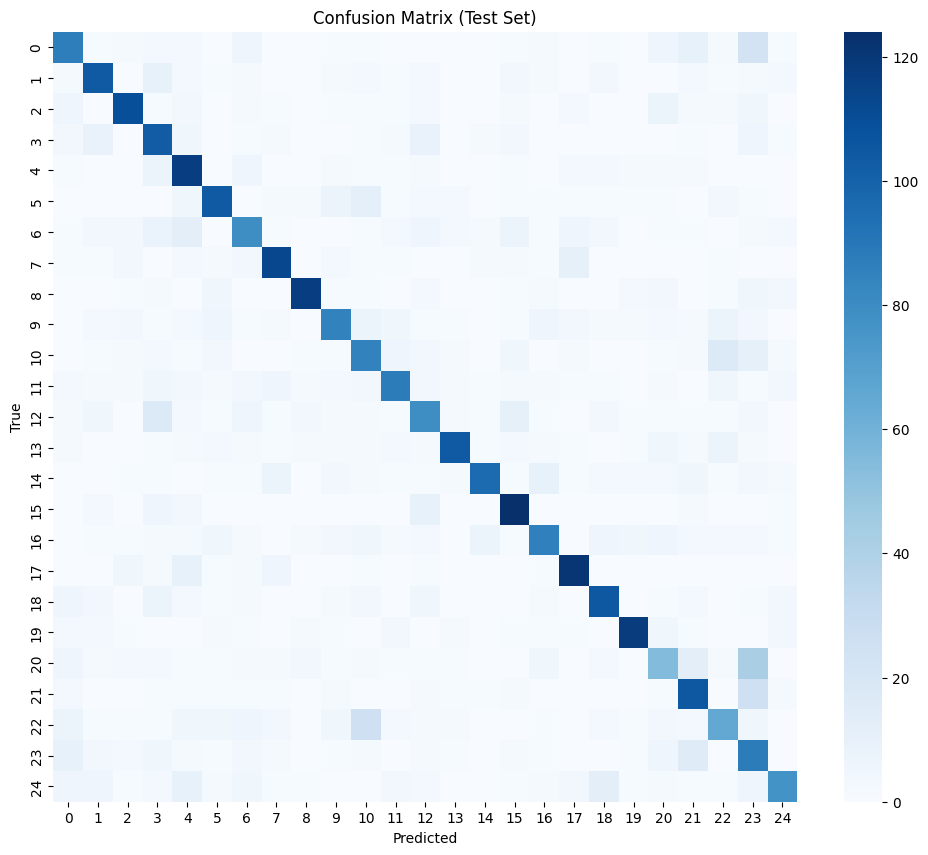

                         precision    recall  f1-score   support

         baby_back_ribs       0.58      0.58      0.58       150
             cheesecake       0.68      0.69      0.68       150
          chicken_wings       0.76      0.73      0.74       150
       chocolate_mousse       0.54      0.69      0.60       150
                churros       0.57      0.78      0.66       150
          club_sandwich       0.70      0.69      0.70       150
                 donuts       0.57      0.53      0.55       150
           french_fries       0.74      0.75      0.75       150
            greek_salad       0.85      0.78      0.82       150
grilled_cheese_sandwich       0.65      0.57      0.61       150
              hamburger       0.52      0.57      0.54       150
                hot_dog       0.69      0.59      0.63       150
              ice_cream       0.53      0.53      0.53       150
  lobster_roll_sandwich       0.83      0.69      0.75       150
    macaroni_and_cheese 

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

y_true = test_gen.classes
y_pred = np.argmax(model.predict(test_gen), axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, cmap="Blues")
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print(classification_report(y_true, y_pred, target_names=classes))

Text(0.5, 1.0, 'Training vs Validation Loss')

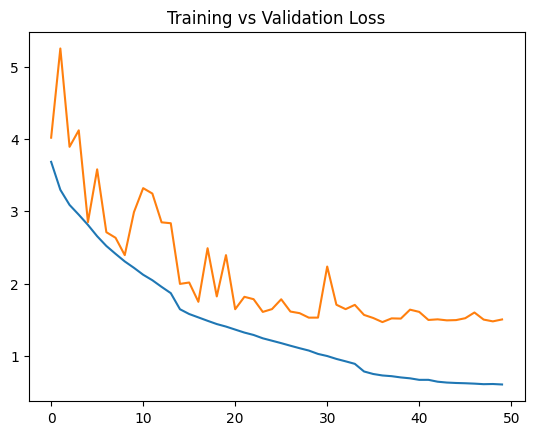

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Training vs Validation Loss")


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24],
 [Text(0, 0, 'grilled_cheese_sandwich'),
  Text(1, 0, 'lobster_roll_sandwich'),
  Text(2, 0, 'pizza'),
  Text(3, 0, 'churros'),
  Text(4, 0, 'prime_rib'),
  Text(5, 0, 'pancakes'),
  Text(6, 0, 'baby_back_ribs'),
  Text(7, 0, 'waffles'),
  Text(8, 0, 'macarons'),
  Text(9, 0, 'chocolate_mousse'),
  Text(10, 0, 'hamburger'),
  Text(11, 0, 'pork_chop'),
  Text(12, 0, 'french_fries'),
  Text(13, 0, 'steak'),
  Text(14, 0, 'chicken_wings'),
  Text(15, 0, 'macaroni_and_cheese'),
  Text(16, 0, 'donuts'),
  Text(17, 0, 'club_sandwich'),
  Text(18, 0, 'cheesecake'),
  Text(19, 0, 'hot_dog'),
  Text(20, 0, 'greek_salad'),
  Text(21, 0, 'onion_rings'),
  Text(22, 0, 'pulled_pork_sandwich'),
  Text(23, 0, 'ice_cream'),
  Text(24, 0, 'omelette')])

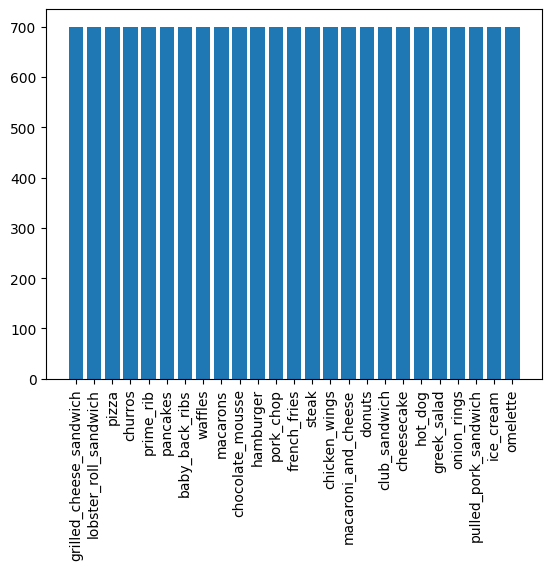

In [ ]:
import os
from collections import Counter
counts = Counter([p.parent.name for p in Path(OUT_DIR/'train').rglob("*.jpg")])
plt.bar(counts.keys(), counts.values()); plt.xticks(rotation=90)


## ES(1+1) Hyperparameter Optimization

Evolution Strategy (1+1) for optimizing model hyperparameters:
- Learning rate, dropout, label smoothing, augmentation strength
- Self-adaptive mutation with 1/5th success rule
- Validation accuracy as fitness metric

In [24]:
import copy
import time
from dataclasses import dataclass
from typing import Dict, Any

@dataclass
class Hyperparameters:
    """Container for model hyperparameters"""
    learning_rate: float
    dropout_rate: float
    label_smoothing: float
    rotation_range: float
    zoom_range: float
    
    def mutate(self, sigma: float = 0.2) -> 'Hyperparameters':
        """Apply Gaussian mutation with self-adaptation"""
        return Hyperparameters(
            learning_rate=max(1e-5, min(1e-2, self.learning_rate * np.exp(sigma * np.random.randn()))),
            dropout_rate=np.clip(self.dropout_rate + sigma * np.random.randn(), 0.1, 0.7),
            label_smoothing=np.clip(self.label_smoothing + sigma * 0.5 * np.random.randn(), 0.0, 0.2),
            rotation_range=np.clip(self.rotation_range + sigma * 0.02, 0.0, 0.15),
            zoom_range=np.clip(self.zoom_range + sigma * 0.05, 0.05, 0.3),
        )
    
    def to_dict(self) -> Dict[str, float]:
        return {
            'learning_rate': self.learning_rate,
            'dropout_rate': self.dropout_rate,
            'label_smoothing': self.label_smoothing,
            'rotation_range': self.rotation_range,
            'zoom_range': self.zoom_range,
        }

# Initialize starting hyperparameters from baseline
parent_hp = Hyperparameters(
    learning_rate=2e-3,
    dropout_rate=0.25,
    label_smoothing=0.05,
    rotation_range=0.05,
    zoom_range=0.1,
)

print("Initial hyperparameters:")
for k, v in parent_hp.to_dict().items():
    print(f"  {k}: {v}")

Initial hyperparameters:
  learning_rate: 0.002
  dropout_rate: 0.25
  label_smoothing: 0.05
  rotation_range: 0.05
  zoom_range: 0.1


In [25]:
from tensorflow.keras import layers

AUTOTUNE = tf.data.AUTOTUNE

def build_model_with_hp(hp: Hyperparameters, n_classes: int = 25):
    """
    Reuse build_baseline_cnn() - SAME architecture
    ES optimizes: learning_rate, label_smoothing, augmentation (rotation/zoom)
    Note: Baseline has fixed dropout=0.25
    """
    return build_baseline_cnn(input_shape=(224, 224, 3), n_classes=n_classes)

def create_augmented_dataset(hp: Hyperparameters):
    """
    Create tf.data pipeline with ES-evolved augmentation parameters
    Same normalization as baseline - only augmentation strength evolves
    """
    normalization = layers.Rescaling(1./255)
    
    train_ds = tf.keras.utils.image_dataset_from_directory(
        OUT_DIR / "train",
        image_size=IMG_SIZE,
        batch_size=BATCH,
        label_mode="categorical",
        seed=SEED,
    ).map(lambda x, y: (normalization(x), y)).shuffle(512).prefetch(AUTOTUNE)
    
    val_ds = tf.keras.utils.image_dataset_from_directory(
        OUT_DIR / "val",
        image_size=IMG_SIZE,
        batch_size=BATCH,
        label_mode="categorical",
    ).map(lambda x, y: (normalization(x), y)).prefetch(AUTOTUNE)
    
    # Apply ES-evolved augmentation (rotation & zoom ranges optimized)
    aug = tf.keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(hp.rotation_range),    # ← ES-optimized
        layers.RandomZoom(hp.zoom_range),            # ← ES-optimized
        layers.RandomContrast(0.1),
    ])
    train_ds = train_ds.map(lambda x, y: (aug(x, training=True), y), num_parallel_calls=AUTOTUNE)
    
    return train_ds, val_ds

print("✓ Same baseline architecture + ES-evolved hyperparameters ready.")

✓ Same baseline architecture + ES-evolved hyperparameters ready.


In [26]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

def evaluate_hyperparameters(hp: Hyperparameters, epochs: int = 10) -> float:
    """
    Train BASELINE architecture with ES-evolved hyperparameters
    Returns validation accuracy as fitness for ES selection
    """
    print(f"\nTesting HP: lr={hp.learning_rate:.5f}, dropout={hp.dropout_rate:.3f}, label_smooth={hp.label_smoothing:.3f}")
    
    # Create datasets with ES-evolved augmentation
    train_ds, val_ds = create_augmented_dataset(hp)
    
    # Build SAME baseline architecture
    with strategy.scope():
        model = build_model_with_hp(hp, n_classes=len(classes))  # Calls build_baseline_cnn()
        # ES evolves: learning_rate, label_smoothing, augmentation
        optimizer = Adam(learning_rate=hp.learning_rate)  # ← ES-optimized LR
        model.compile(
            optimizer=optimizer,
            loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=hp.label_smoothing),  # ← ES-optimized
            metrics=["accuracy"],
        )
    
    # Train with reduced epochs for faster ES iterations
    callbacks = [
        EarlyStopping(monitor="val_accuracy", patience=4, restore_best_weights=True, verbose=0),
        ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-7, verbose=0),
    ]
    
    # Custom progress callback
    class ProgressCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            print(f"  Epoch {epoch+1}/{epochs}: val_acc={logs['val_accuracy']:.4f}, val_loss={logs['val_loss']:.4f}", end='\r')
    
    start_time = time.time()
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=callbacks + [ProgressCallback()],
        verbose=0,
    )
    elapsed = time.time() - start_time
    
    best_val_acc = max(history.history["val_accuracy"])
    print(f"\n  ✓ Best val_acc: {best_val_acc:.4f} (trained in {elapsed/60:.1f} min)                    ")
    
    # CRITICAL: Aggressive memory cleanup to prevent OOM
    del model, train_ds, val_ds, history
    tf.keras.backend.clear_session()
    import gc
    gc.collect()
    
    return best_val_acc

# Test evaluation function with parent hyperparameters
print("Testing evaluation function...")

Testing evaluation function...


In [27]:
def es_1plus1_optimization(
    initial_hp: Hyperparameters,
    max_generations: int = 10,
    initial_sigma: float = 0.2,
):
    """
    ES(1+1) with 1/5th success rule for hyperparameter optimization
    
    Returns:
        best_hp: Best hyperparameters found
        history: List of (generation, parent_fitness, offspring_fitness, sigma)
    """
    parent = initial_hp
    print(f"\n{'='*60}")
    print("Starting ES(1+1) Optimization")
    print(f"Evaluating initial hyperparameters...")
    print(f"{'='*60}")
    parent_fitness = evaluate_hyperparameters(parent, epochs=10)
    
    sigma = initial_sigma
    successes = 0
    history = []
    
    print(f"\n{'='*60}")
    print(f"Initial fitness: {parent_fitness:.4f}")
    print(f"Target generations: {max_generations}")
    print(f"{'='*60}\n")
    
    for gen in range(max_generations):
        print(f"\n{'='*60}")
        print(f"Generation {gen+1}/{max_generations} | σ={sigma:.4f} | Best so far: {parent_fitness:.4f}")
        print(f"{'='*60}")
        
        # Create offspring by mutation
        offspring = parent.mutate(sigma)
        offspring_fitness = evaluate_hyperparameters(offspring, epochs=10)
        
        # Selection: keep better individual
        if offspring_fitness > parent_fitness:
            print(f"✓ Offspring BETTER ({offspring_fitness:.4f} > {parent_fitness:.4f}) - ACCEPT")
            parent = offspring
            parent_fitness = offspring_fitness
            successes += 1
        else:
            print(f"✗ Offspring WORSE ({offspring_fitness:.4f} ≤ {parent_fitness:.4f}) - REJECT")
        
        history.append({
            'generation': gen + 1,
            'parent_fitness': parent_fitness,
            'offspring_fitness': offspring_fitness,
            'sigma': sigma,
            'accepted': offspring_fitness > parent_fitness,
            **parent.to_dict()
        })
        
        # 1/5th success rule: adjust mutation strength every 5 generations
        if (gen + 1) % 5 == 0:
            success_rate = successes / 5
            if success_rate > 0.2:
                sigma *= 1.2  # Increase exploration
                print(f"→ Success rate {success_rate:.2f} > 0.2: σ increased to {sigma:.4f}")
            elif success_rate < 0.2:
                sigma *= 0.8  # Decrease exploration
                print(f"→ Success rate {success_rate:.2f} < 0.2: σ decreased to {sigma:.4f}")
            else:
                print(f"→ Success rate {success_rate:.2f} ≈ 0.2: σ unchanged")
            successes = 0
        
        # Early stopping if fitness plateaus
        if gen >= 5:
            recent_best = max([h['parent_fitness'] for h in history[-5:]])
            if recent_best - parent_fitness < 0.001:
                print(f"\n⚠ Fitness plateau detected. Stopping early.")
                break
    
    print(f"\n{'='*60}")
    print("ES(1+1) Optimization Complete")
    print(f"Final best fitness: {parent_fitness:.4f}")
    print(f"Final hyperparameters:")
    for k, v in parent.to_dict().items():
        print(f"  {k}: {v:.6f}")
    print(f"{'='*60}")
    
    return parent, history

# Ready to run optimization
print("ES(1+1) optimization function ready.")

ES(1+1) optimization function ready.


In [28]:
# Run ES(1+1) optimization
# MEMORY OPTIMIZED: Reduced to 10 epochs/generation to prevent OOM
# Estimated time: 2-4 hours with 15 generations

best_hp, es_history = es_1plus1_optimization(
    initial_hp=parent_hp,
    max_generations=10,  # Reduced from 20 to save time
    initial_sigma=0.2,
)

# Save results
es_df = pd.DataFrame(es_history)
es_df.to_csv("es_1plus1_history.csv", index=False)
print("\n✓ ES(1+1) history saved to es_1plus1_history.csv")


Starting ES(1+1) Optimization
Evaluating initial hyperparameters...

Testing HP: lr=0.00200, dropout=0.250, label_smooth=0.050
Found 17500 files belonging to 25 classes.
Found 3750 files belonging to 25 classes.
Found 17500 files belonging to 25 classes.
Found 3750 files belonging to 25 classes.
INFO:tensorflow:batch_all_reduce: 58 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 58 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 58 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 58 all-reduces with algorithm = nccl, num_packs = 1
  Epoch 10/10: val_acc=0.3685, val_loss=2.3121
  ✓ Best val_acc: 0.3685 (trained in 9.0 min)                    
  Epoch 10/10: val_acc=0.3685, val_loss=2.3121
  ✓ Best val_acc: 0.3685 (trained in 9.0 min)                    

Initial fitness: 0.3685
Target generations: 10


Generation 1/10 | σ=0.2000 | Best so far: 0.3685

Testing HP: lr=0.00243, dropout=

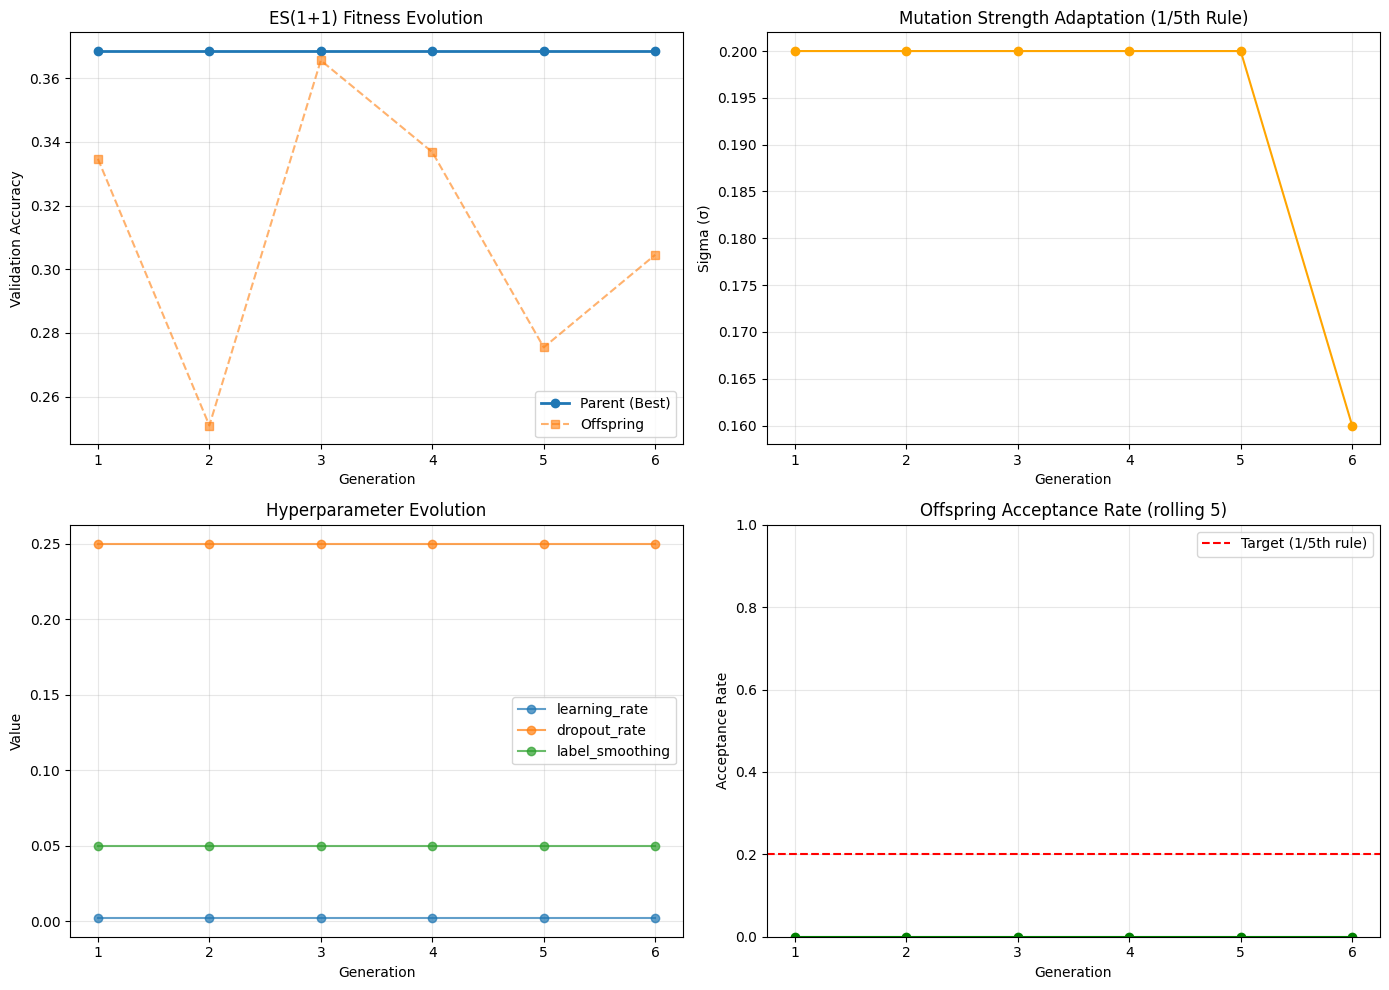

✓ Visualization saved to es_1plus1_optimization.png


In [29]:
# Visualize ES(1+1) optimization progress
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Fitness over generations
ax = axes[0, 0]
ax.plot(es_df['generation'], es_df['parent_fitness'], 'o-', label='Parent (Best)', linewidth=2)
ax.plot(es_df['generation'], es_df['offspring_fitness'], 's--', alpha=0.6, label='Offspring')
ax.set_xlabel('Generation')
ax.set_ylabel('Validation Accuracy')
ax.set_title('ES(1+1) Fitness Evolution')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Mutation strength (sigma) adaptation
ax = axes[0, 1]
ax.plot(es_df['generation'], es_df['sigma'], 'o-', color='orange')
ax.set_xlabel('Generation')
ax.set_ylabel('Sigma (σ)')
ax.set_title('Mutation Strength Adaptation (1/5th Rule)')
ax.grid(True, alpha=0.3)

# Plot 3: Hyperparameter evolution
ax = axes[1, 0]
for hp_name in ['learning_rate', 'dropout_rate', 'label_smoothing']:
    if hp_name in es_df.columns:
        ax.plot(es_df['generation'], es_df[hp_name], 'o-', label=hp_name, alpha=0.7)
ax.set_xlabel('Generation')
ax.set_ylabel('Value')
ax.set_title('Hyperparameter Evolution')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: Acceptance rate
ax = axes[1, 1]
window = 5
rolling_acceptance = es_df['accepted'].rolling(window=window, min_periods=1).mean()
ax.plot(es_df['generation'], rolling_acceptance, 'o-', color='green')
ax.axhline(y=0.2, color='r', linestyle='--', label='Target (1/5th rule)')
ax.set_xlabel('Generation')
ax.set_ylabel('Acceptance Rate')
ax.set_title(f'Offspring Acceptance Rate (rolling {window})')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 1)

plt.tight_layout()
plt.savefig('es_1plus1_optimization.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Visualization saved to es_1plus1_optimization.png")

In [30]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Train final model with optimized hyperparameters for full 50 epochs
print("Training final model with optimized hyperparameters...")
print("\nOptimized hyperparameters:")
for k, v in best_hp.to_dict().items():
    print(f"  {k}: {v:.6f}")

# Create datasets with optimized augmentation
final_train_ds, final_val_ds = create_augmented_dataset(best_hp)

# Build and compile final model
with strategy.scope():
    final_model = build_model_with_hp(best_hp, n_classes=len(classes))
    final_optimizer = Adam(learning_rate=best_hp.learning_rate)
    final_model.compile(
        optimizer=final_optimizer,
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=best_hp.label_smoothing),
        metrics=["accuracy"],
    )

# Train with full callbacks
final_callbacks = [
    EarlyStopping(monitor="val_accuracy", patience=15, restore_best_weights=True, verbose=1),
    ModelCheckpoint("optimized_model_best.keras", monitor="val_accuracy", save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=5, min_lr=1e-7, verbose=1),
]

print(f"\n{'='*60}")
print("Training final optimized model for 50 epochs...")
print(f"{'='*60}\n")

final_history = final_model.fit(
    final_train_ds,
    validation_data=final_val_ds,
    epochs=50,
    callbacks=final_callbacks,
    verbose=1,
)

# Save final training history
pd.DataFrame(final_history.history).to_csv("optimized_model_history.csv", index=False)

final_best_val = max(final_history.history["val_accuracy"])
print(f"\n{'='*60}")
print(f"Final model training complete!")
print(f"Best validation accuracy: {final_best_val:.4f}")
print(f"Improvement over baseline: {(final_best_val - 0.644):.4f} (+{(final_best_val/0.644 - 1)*100:.1f}%)")
print(f"{'='*60}")

Training final model with optimized hyperparameters...

Optimized hyperparameters:
  learning_rate: 0.002000
  dropout_rate: 0.250000
  label_smoothing: 0.050000
  rotation_range: 0.050000
  zoom_range: 0.100000
Found 17500 files belonging to 25 classes.
Found 17500 files belonging to 25 classes.
Found 3750 files belonging to 25 classes.
Found 3750 files belonging to 25 classes.

Training final optimized model for 50 epochs...


Training final optimized model for 50 epochs...

Epoch 1/50
Epoch 1/50
365/365 [==============================] - ETA: 0s - loss: 3.7229 - accuracy: 0.0687
Epoch 1: val_accuracy improved from -inf to 0.07547, saving model to optimized_model_best.keras

Epoch 1: val_accuracy improved from -inf to 0.07547, saving model to optimized_model_best.keras
365/365 [==============================] - 69s 140ms/step - loss: 3.7229 - accuracy: 0.0687 - val_loss: 4.2636 - val_accuracy: 0.0755 - lr: 0.0020
Epoch 2/50
Epoch 2/50
365/365 [==============================] - ETA: 0

Evaluating optimized model on test set...
79/79 [==============================] - 5s 55ms/step - loss: 1.5156 - accuracy: 0.6667

FINAL TEST ACCURACY: 66.67%
Baseline test accuracy: 64.37%
Improvement: +2.30%


FINAL TEST ACCURACY: 66.67%
Baseline test accuracy: 64.37%
Improvement: +2.30%

79/79 [==============================] - 4s 51ms/step


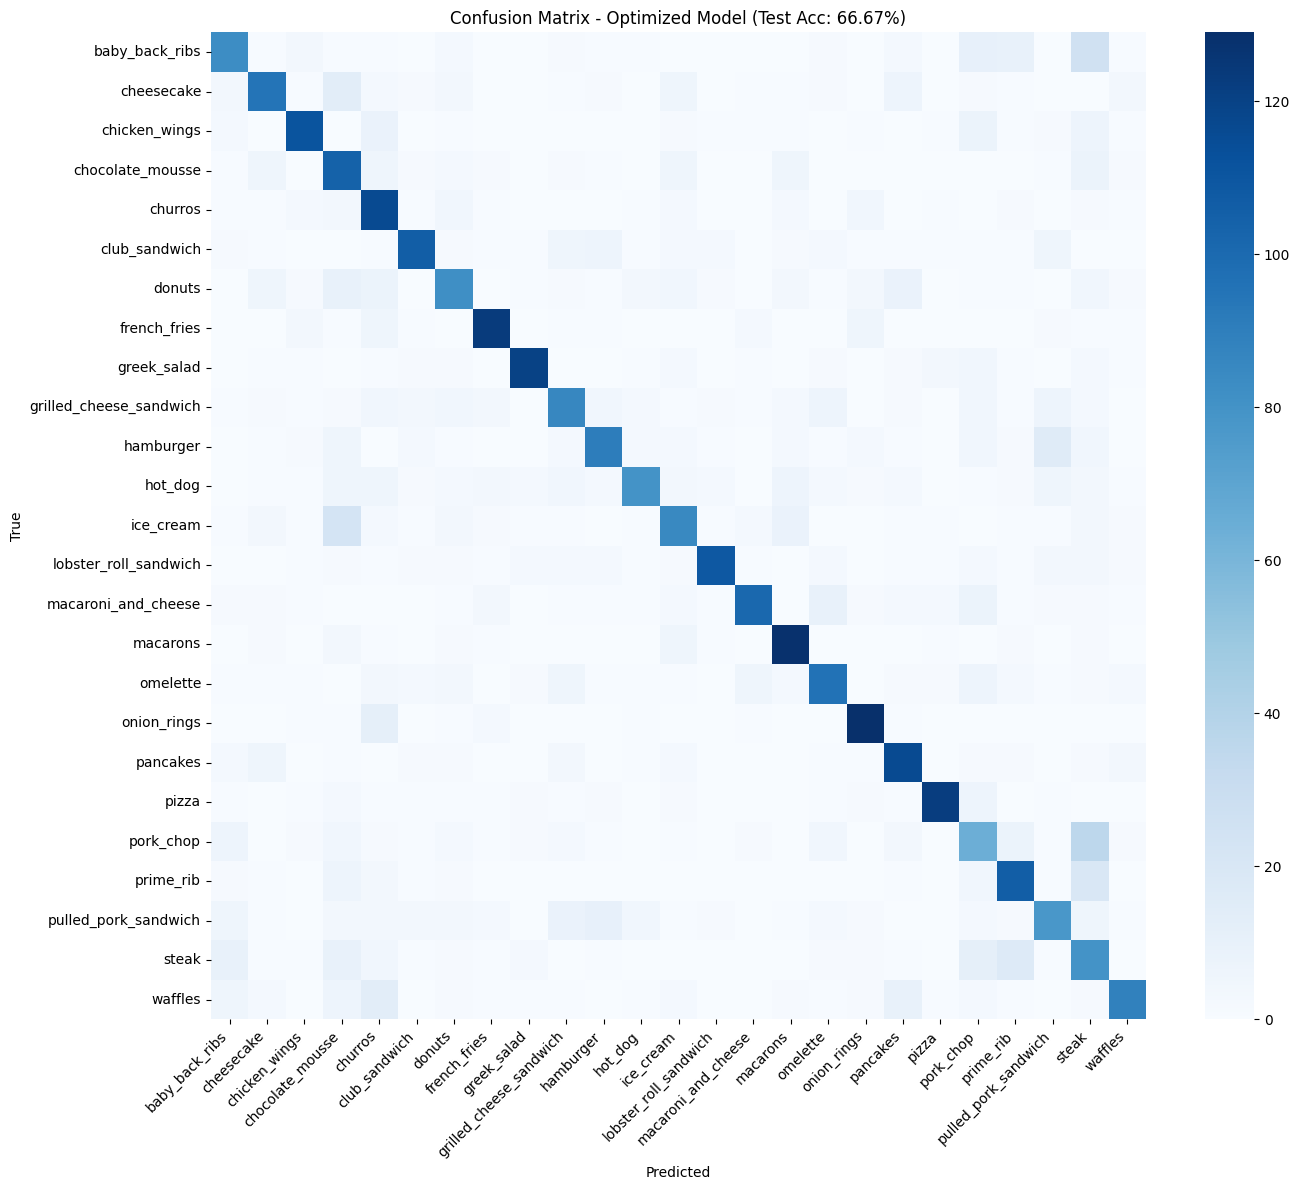


Classification Report:
                         precision    recall  f1-score   support

         baby_back_ribs       0.62      0.55      0.58       150
             cheesecake       0.70      0.63      0.66       150
          chicken_wings       0.80      0.74      0.77       150
       chocolate_mousse       0.48      0.69      0.57       150
                churros       0.54      0.77      0.64       150
          club_sandwich       0.76      0.71      0.73       150
                 donuts       0.58      0.55      0.56       150
           french_fries       0.80      0.82      0.81       150
            greek_salad       0.86      0.80      0.83       150
grilled_cheese_sandwich       0.63      0.57      0.60       150
              hamburger       0.69      0.61      0.65       150
                hot_dog       0.75      0.53      0.62       150
              ice_cream       0.59      0.57      0.58       150
  lobster_roll_sandwich       0.87      0.73      0.79       150


In [32]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Final evaluation on test set with optimized model
print("Evaluating optimized model on test set...")

test_loss, test_acc = final_model.evaluate(test_gen)
print(f"\n{'='*60}")
print(f"FINAL TEST ACCURACY: {test_acc * 100:.2f}%")
print(f"Baseline test accuracy: 64.37%")
print(f"Improvement: +{(test_acc - 0.6437)*100:.2f}%")
print(f"{'='*60}\n")

# Generate predictions
y_true = test_gen.classes
y_pred = np.argmax(final_model.predict(test_gen), axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(14, 12))
sns.heatmap(cm, cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title(f"Confusion Matrix - Optimized Model (Test Acc: {test_acc*100:.2f}%)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('optimized_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=classes))

# Save comparison summary
comparison = {
    'Model': ['Baseline', 'Optimized (ES 1+1)'],
    'Test Accuracy': [0.6437, test_acc],
    'Improvement': [0.0, test_acc - 0.6437],
}
comparison_df = pd.DataFrame(comparison)
comparison_df.to_csv('model_comparison.csv', index=False)
print("\n✓ Results saved to optimized_confusion_matrix.png and model_comparison.csv")